<a href="https://colab.research.google.com/github/ucancallmetigger-ui/Bitcoin_prediction/blob/main/Bitcoin_RegimeForge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[*********************100%***********************]  1 of 1 completed


Training Direction Model...
Epoch 0 - Loss: 0.693633
Epoch 20 - Loss: 0.688331
Epoch 40 - Loss: 0.664924
Epoch 60 - Loss: 0.601134
Training Volatility Model...
Epoch 0 - Loss: 1.058379
Epoch 20 - Loss: 1.057905
Epoch 40 - Loss: 1.056851
Epoch 60 - Loss: 1.052664
Training Crash Model...
Epoch 0 - Loss: 0.391646
Epoch 20 - Loss: 0.202754
Epoch 40 - Loss: 0.187596
Epoch 60 - Loss: 0.197283
Directional Accuracy: 0.5111
Volatility MAE: 0.7146
Volatility RMSE: 0.8453
Crash Precision: 0.0000
Crash Recall: 0.0000
Permutation Importance: {'lag1': np.float64(0.012499999999999973), 'lag2': np.float64(0.002499999999999963), 'lag3': np.float64(-0.003333333333333349), 'vol5': np.float64(0.01222222222222219), 'vol20': np.float64(-0.014166666666666727), 'rsi': np.float64(-0.009444444444444488)}
Sharpe Ratio: 0.5702
6-Month Median Forecast: nan USD
90% Confidence Interval: [nan - nan] USD
Black Swan Stress Test - Strategy: 0.96x | Market: 0.43x


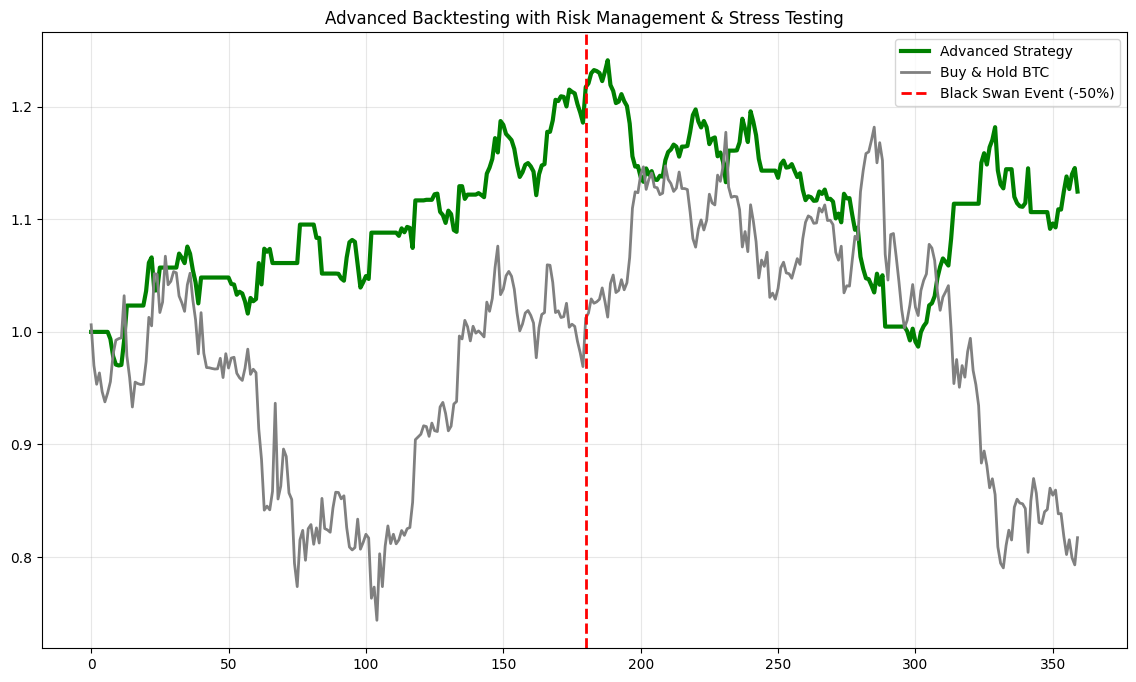

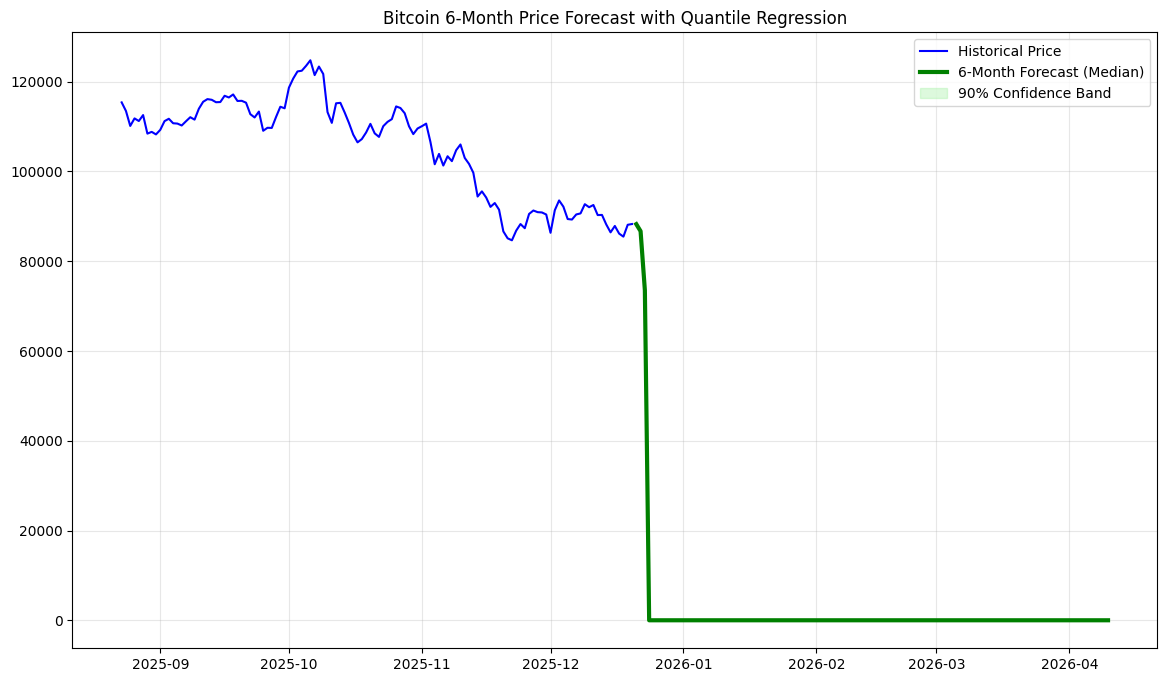

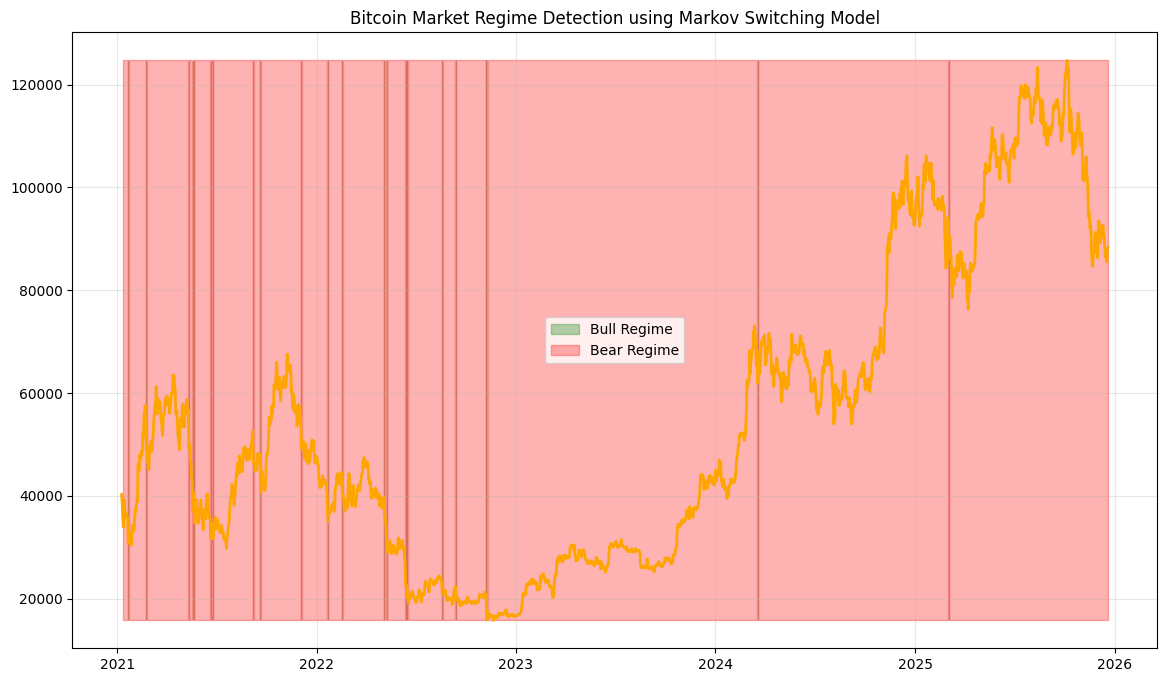

پروژه غول‌آخر با موفقیت اجرا شد!
فایل‌ها ذخیره شدند: advanced_backtest.png, forecast_advanced.png, regime_detection.png, shap_summary.png


In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, mean_absolute_error, mean_squared_error
import statsmodels.api as sm
from statsmodels.tsa.regime_switching.markov_autoregression import MarkovAutoregression
from statsmodels.regression.quantile_regression import QuantReg
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
from sklearn.base import BaseEstimator, ClassifierMixin
import shap
import warnings
warnings.filterwarnings("ignore")

ticker = "BTC-USD"
df = yf.download(ticker, start="2020-12-20")
df = df[['Open', 'High', 'Low', 'Close', 'Volume']]
df.columns = ['open', 'high', 'low', 'close', 'volume']

df['returns'] = np.log(df['close'] / df['close'].shift(1))
df['lag1'] = df['returns'].shift(1)
df['lag2'] = df['returns'].shift(2)
df['lag3'] = df['returns'].shift(3)
df['vol5'] = df['returns'].rolling(5).std()
df['vol20'] = df['returns'].rolling(20).std()

def compute_rsi(series, period=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

df['rsi'] = compute_rsi(df['close'], 14)
df['target_direction'] = (df['returns'].shift(-1) > 0).astype(int)
df['target_crash'] = (df['returns'].shift(-1) < -0.05).astype(int)
df = df.dropna()

features = ['lag1', 'lag2', 'lag3', 'vol5', 'vol20', 'rsi']

mean = df[features].mean()
std = df[features].std()
df[features] = (df[features] - mean) / std

model_regime = MarkovAutoregression(df['returns'], k_regimes=2, order=2)
res_regime = model_regime.fit(disp=False)
prob_bear = res_regime.smoothed_marginal_probabilities.iloc[:, 0]
df['regime'] = (prob_bear > 0.5).astype(int)

seq_length = 10
X = []
y_dir = []
y_vol = []
y_crash = []

for i in range(seq_length, len(df)-1):
    X.append(df[features].iloc[i-seq_length:i].values)
    y_dir.append(df['target_direction'].iloc[i])
    y_vol.append(df['vol5'].iloc[i+1])
    y_crash.append(df['target_crash'].iloc[i])

X = np.array(X)
y_dir = np.array(y_dir, dtype=np.float32)
y_vol = np.array(y_vol, dtype=np.float32)
y_crash = np.array(y_crash, dtype=np.float32)

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(-1)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class AdvancedLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=256, num_layers=3, dropout=0.3, classifier=True):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc1 = nn.Linear(hidden_size, 128)
        self.fc2 = nn.Linear(128, 1)
        self.dropout = nn.Dropout(dropout)
        self.classifier = classifier
        self.sigmoid = nn.Sigmoid() if classifier else None
    def forward(self, x):
        out, (h, _) = self.lstm(x)
        out = self.dropout(torch.relu(self.fc1(h[-1])))
        out = self.fc2(out)
        return self.sigmoid(out) if self.classifier else out.squeeze()

input_size = len(features)
train_ratio = 0.8
train_size = int(train_ratio * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_dir_train, y_dir_test = y_dir[:train_size], y_dir[train_size:]
y_vol_train, y_vol_test = y_vol[:train_size], y_vol[train_size:]
y_crash_train, y_crash_test = y_crash[:train_size], y_crash[train_size:]

def train_model(model, X_tr, y_tr, classifier=True, epochs=80):
    loader = DataLoader(TimeSeriesDataset(X_tr, y_tr), batch_size=64, shuffle=True)
    optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)
    criterion = nn.BCELoss() if classifier else nn.MSELoss()
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        for xb, yb in loader:
            optimizer.zero_grad()
            pred = model(xb)
            loss = criterion(pred, yb)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            epoch_loss += loss.item()
        scheduler.step(epoch_loss)
        if epoch % 20 == 0:
            print(f"Epoch {epoch} - Loss: {epoch_loss / len(loader):.6f}")

print("Training Direction Model...")
model_direction = AdvancedLSTM(input_size)
train_model(model_direction, X_train, y_dir_train)

print("Training Volatility Model...")
model_volatility = AdvancedLSTM(input_size, classifier=False)
train_model(model_volatility, X_train, y_vol_train, classifier=False)

print("Training Crash Model...")
model_crash = AdvancedLSTM(input_size)
train_model(model_crash, X_train, y_crash_train)

model_direction.eval()
with torch.no_grad():
    pred_prob_dir = model_direction(torch.tensor(X_test, dtype=torch.float32)).numpy()
pred_dir = (pred_prob_dir > 0.5).astype(int)
print(f"Directional Accuracy: {accuracy_score(y_dir_test, pred_dir):.4f}")

model_volatility.eval()
with torch.no_grad():
    pred_vol = model_volatility(torch.tensor(X_test, dtype=torch.float32)).numpy()
print(f"Volatility MAE: {mean_absolute_error(y_vol_test, pred_vol):.4f}")
print(f"Volatility RMSE: {np.sqrt(mean_squared_error(y_vol_test, pred_vol)):.4f}")

model_crash.eval()
with torch.no_grad():
    pred_prob_crash = model_crash(torch.tensor(X_test, dtype=torch.float32)).numpy()
pred_crash = (pred_prob_crash > 0.5).astype(int)
print(f"Crash Precision: {precision_score(y_crash_test, pred_crash, zero_division=0):.4f}")
print(f"Crash Recall: {recall_score(y_crash_test, pred_crash, zero_division=0):.4f}")

X_qr_features_only = df[features + ['regime']].iloc[seq_length:len(df)-1].copy()

y_qr = df['returns'].iloc[seq_length+1:].copy()

X_qr = sm.add_constant(X_qr_features_only.set_index(y_qr.index))

qr_low = QuantReg(y_qr, X_qr).fit(q=0.05)
qr_med = QuantReg(y_qr, X_qr).fit(q=0.5)
qr_high = QuantReg(y_qr, X_qr).fit(q=0.95)

class AdvancedLSTM_Logits(nn.Module):
    def __init__(self, original_model):
        super().__init__()
        self.original_model = original_model
        self.original_model.eval()

    def forward(self, x):
        out, (h, _) = self.original_model.lstm(x)
        out = self.original_model.dropout(torch.relu(self.original_model.fc1(h[-1])))
        out = self.original_model.fc2(out)
        return out
logit_model_direction = AdvancedLSTM_Logits(model_direction)

explainer = shap.DeepExplainer(logit_model_direction, torch.tensor(X_train[:200], dtype=torch.float32))
shap_values = explainer.shap_values(torch.tensor(X_test[:50], dtype=torch.float32), check_additivity=False)

shap_values_for_plot = shap_values.mean(axis=1).squeeze()
X_test_for_plot = X_test[:50].mean(axis=1)

shap.summary_plot(shap_values_for_plot, X_test_for_plot, feature_names=features, show=False)
plt.savefig('shap_summary.png', dpi=300, bbox_inches='tight')
plt.close()

class Wrapper(BaseEstimator, ClassifierMixin):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        X_t = torch.tensor(X.reshape(-1, seq_length, input_size), dtype=torch.float32)
        with torch.no_grad():
            return (model_direction(X_t).numpy() > 0.5).astype(int)

pi = permutation_importance(Wrapper(), X_test.reshape(len(X_test), -1), y_dir_test, n_repeats=10, random_state=42)
print("Permutation Importance:", dict(zip(features, pi.importances_mean)))

backtest_df = df.iloc[seq_length + train_size:len(df)-1].copy().reset_index(drop=True)
backtest_df['pred_prob'] = pred_prob_dir

confidence_high = 0.65
confidence_low = 0.35
no_trade_vol = 0.06
stop_loss = -0.12
position_size = 0.6

backtest_df['position'] = 0.0
for i in range(1, len(backtest_df)):
    vol = backtest_df['vol5'].iloc[i]
    prob = backtest_df['pred_prob'].iloc[i]
    current_pos = backtest_df['position'].iloc[i-1]
    if vol > no_trade_vol:
        backtest_df.loc[i, 'position'] = 0.0
    elif prob > confidence_high:
        backtest_df.loc[i, 'position'] = position_size
    elif prob < confidence_low:
        backtest_df.loc[i, 'position'] = -position_size
    else:
        backtest_df.loc[i, 'position'] = current_pos

backtest_df['strategy_ret'] = backtest_df['position'].shift(1) * backtest_df['returns']
backtest_df['strategy_ret'] = np.where(backtest_df['strategy_ret'] < stop_loss, stop_loss, backtest_df['strategy_ret'])
backtest_df['cum_strategy'] = (1 + backtest_df['strategy_ret'].fillna(0)).cumprod()
backtest_df['cum_market'] = (1 + backtest_df['returns']).cumprod()

sharpe = np.sqrt(252) * backtest_df['strategy_ret'].mean() / backtest_df['strategy_ret'].std() if backtest_df['strategy_ret'].std() > 0 else 0
print(f"Sharpe Ratio: {sharpe:.4f}")

current_price = df['close'].iloc[-1]
prices = [current_price]
low_ci = current_price
high_ci = current_price
last_feat = df[features].iloc[-1].values
last_reg = df['regime'].iloc[-1]

for _ in range(180):
    data_row = [1.0] + last_feat.tolist() + [last_reg]
    full_column_names = ['const'] + features + ['regime']
    X_new = pd.DataFrame([data_row], columns=full_column_names)

    r_med = qr_med.predict(X_new)[0]
    r_low = qr_low.predict(X_new)[0]
    r_high = qr_high.predict(X_new)[0]
    current_price *= np.exp(r_med)
    prices.append(current_price)
    low_ci *= np.exp(r_low)
    high_ci *= np.exp(r_high)
    new_lag1 = r_med
    new_lag2 = last_feat[0]
    new_lag3 = last_feat[1]
    new_vol5 = np.std(np.append(last_feat[2:4], [new_lag1, new_lag2, new_lag3]))
    new_vol20 = np.std(np.append(last_feat[4], np.repeat(r_med, 19)))
    new_rsi = 50
    last_feat = (np.array([new_lag1, new_lag2, new_lag3, new_vol5, new_vol20, new_rsi]) - mean.values) / std.values

print(f"6-Month Median Forecast: {prices[-1]:,.0f} USD")
print(f"90% Confidence Interval: [{low_ci:,.0f} - {high_ci:,.0f}] USD")

stress = backtest_df.copy()
mid = len(stress) // 2
stress.loc[mid, 'returns'] -= 0.5
stress['strategy_ret'] = stress['position'].shift(1) * stress['returns']
stress['strategy_ret'] = np.where(stress['strategy_ret'] < stop_loss, stop_loss, stress['strategy_ret'])
stress_strategy = (1 + stress['strategy_ret'].fillna(0)).cumprod().iloc[-1]
stress_market = (1 + stress['returns']).cumprod().iloc[-1]
print(f"Black Swan Stress Test - Strategy: {stress_strategy:.2f}x | Market: {stress_market:.2f}x")

plt.figure(figsize=(14,8))
plt.plot(backtest_df['cum_strategy'], label='Advanced Strategy', linewidth=3, color='green')
plt.plot(backtest_df['cum_market'], label='Buy & Hold BTC', linewidth=2, color='gray')
plt.axvline(mid, color='red', linestyle='--', linewidth=2, label='Black Swan Event (-50%)')
plt.title('Advanced Backtesting with Risk Management & Stress Testing')
plt.legend()
plt.grid(alpha=0.3)
plt.savefig('advanced_backtest.png', dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(14,8))
dates = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=180)
plt.plot(df['close'].tail(120), label='Historical Price', color='blue')
plt.plot(dates, prices[1:], label='6-Month Forecast (Median)', color='green', linewidth=3)
plt.fill_between(dates, low_ci, high_ci, alpha=0.3, color='lightgreen', label='90% Confidence Band')
plt.title('Bitcoin 6-Month Price Forecast with Quantile Regression')
plt.legend()
plt.grid(alpha=0.3)
plt.savefig('forecast_advanced.png', dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(14,8))
plt.plot(df['close'], color='orange', linewidth=2)
plt.fill_between(df.index, df['close'].min(), df['close'].max(), where=df['regime']==1, color='green', alpha=0.3, label='Bull Regime')
plt.fill_between(df.index, df['close'].min(), df['close'].max(), where=df['regime']==0, color='red', alpha=0.3, label='Bear Regime')
plt.title('Bitcoin Market Regime Detection using Markov Switching Model')
plt.legend()
plt.grid(alpha=0.3)
plt.savefig('regime_detection.png', dpi=300, bbox_inches='tight')
plt.show()